In [45]:
import importlib
import matplotlib.pyplot as plt
import mygene
import numpy as np
import pandas as pd
import pickle
import random

from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

np.random.seed(1)
random.seed(1)

In [46]:
import util
import importlib
importlib.reload(util)

N_genes, N_dims, gpt_embeddings = util.retrieve_gpt_gene_embeddings()
random_embeddings = util.generate_random_embeddings(N_genes, N_dims, gpt_embeddings.keys())

### Dosage Sensitive vs Insensitive TFs

In [47]:
with open(util.data_dir / "dosage_sensitivity_TFs.pickle", "rb") as fb:
    dosage_tf_ids= pickle.load(fb)
dosage_sensitive_tf_ids = dosage_tfs["Dosage-sensitive TFs"]
dosage_insensitive_tf_ids = dosage_tfs["Dosage-insensitive TFs"]

In [48]:
mg = mygene.MyGeneInfo()
dosage_sensitive_tf_query = mg.querymany(dosage_sensitive_tf_ids, species='human')
dosage_sensitive_tfs = [x['symbol'] for x in dosage_sensitive_tf_query]
dosage_insensitive_tf_query = mg.querymany(dosage_insensitive_tf_ids, species='human')
dosage_insensitive_tfs = [x['symbol'] for x in dosage_insensitive_tf_query if 'symbol' in x]
print(dosage_sensitive_tf[:10])

1 input query terms found no hit:	['ENSG00000215271']


['TFAP2D', 'NFIX', 'HIVEP2', 'DPF1', 'IKZF2', 'GPBP1', 'FOXJ2', 'KLF6', 'RORA', 'NFATC3']


In [49]:
X_gpt_dosage_sensitive_tfs = np.array([gpt_embeddings[x] for x in dosage_sensitive_tfs if x in gpt_embeddings])
X_gpt_dosage_insensitive_tfs = np.array([gpt_embeddings[x] for x in dosage_insensitive_tfs if x in gpt_embeddings])

X_gpt = np.concatenate((X_gpt_dosage_sensitive_tfs, X_gpt_dosage_insensitive_tfs))
y_gpt = np.concatenate((np.repeat(1,len(X_gpt_dosage_sensitive_tfs)),np.repeat(0,len(X_gpt_dosage_insensitive_tfs))))

In [50]:
X_random_dosage_sensitive_tfs = np.array([random_embeddings[x] for x in dosage_sensitive_tfs if x in random_embeddings])
X_random_dosage_insensitive_tfs = np.array([random_embeddings[x] for x in dosage_insensitive_tfs if x in random_embeddings])

X_random = np.concatenate((X_random_dosage_sensitive_tfs, X_random_dosage_insensitive_tfs))
y_random = np.concatenate((np.repeat(1,len(X_random_dosage_sensitive_tfs)),np.repeat(0,len(X_random_dosage_insensitive_tfs))))

In [51]:
print("GPT Embeddings:")
gpt_logistic_data, gpt_rf_data = util.logistic_random_forest_eval(X_gpt, y_gpt)
print("\nRandom Embeddings:")
util.logistic_random_forest_eval(X_random, y_random);

GPT Embeddings:
Logistic Regression ROC AUC: 0.880 +/- 0.044
Random Forest ROC AUC: 0.907 +/- 0.038

Random Embeddings:
Logistic Regression ROC AUC: 0.465 +/- 0.089
Random Forest ROC AUC: 0.472 +/- 0.075


In [52]:
roc_auc_logistic, tpr_logistic, fpr_logistic = gpt_logistic_data
roc_auc_rf, tpr_rf, fpr_rf = gpt_rf_data

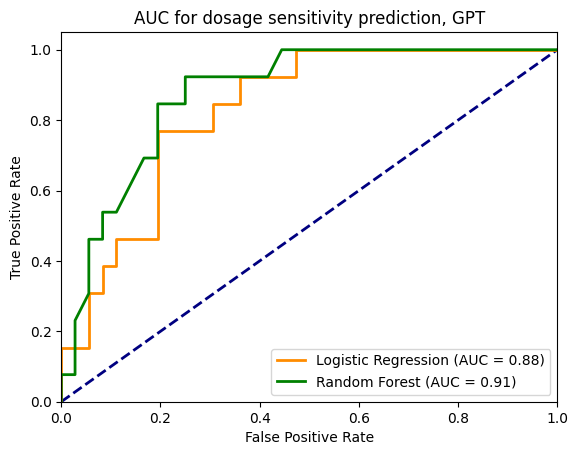

In [53]:
plt.figure()
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.plot(fpr_logistic[0], tpr_logistic[0], color='darkorange', lw=2, label='Logistic Regression (AUC = %0.2f)' % np.mean(roc_auc_logistic))
plt.plot(fpr_rf[0], tpr_rf[0], color='green', lw=2, label='Random Forest (AUC = %0.2f)' % np.mean(roc_auc_rf))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC for dosage sensitivity prediction, GPT')
plt.legend(loc='lower right')
plt.show()